In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps
import seaborn as sns
from scipy import ndimage
from skimage.filters import threshold_minimum, threshold_otsu
import sys
#from skimage.morphology import skeletonize

#Allow Pillow to open very large images
Image.MAX_IMAGE_PIXELS = None

#Check if OpenCV is using optimised code
cv2.useOptimized()

True

In [2]:
# Import HEMnet package
BASE_DIR = Path().resolve().parent
HEMNET_DIR = BASE_DIR.joinpath('HEMnet')
sys.path.append(str(HEMNET_DIR))

from slide import *
from utils import *
from normaliser import IterativeNormaliser

In [3]:
ANNOTATIONS_PATH = Path('/QRISdata/Q1139/ST_Projects/HEMnet/Annotated_Jpegs')
SLIDES_PATH = Path('/gpfs1/scratch/90days/s4436005/Slides')
OUTPUT_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg/03_06_20_testing')
TEMPLATE_SLIDE_PATH = Path('/gpfs1/scratch/90days/s4436005/Slides/1957_T_9668_3_HandE.svs')

ALIGNMENT_MAG = 2
TILE_MAG = 10
#Allow user to select between 'none', 'reinhard', 'macenko' and 'vahadane'
NORMALISER_METHOD = "vahadane"
STANDARDISE_LUMINOSITY = True
VERBOSE = True

#Verbose functions
if VERBOSE:
    verbose_print = lambda *args: print(*args)
    verbose_save_img = lambda img, path, img_type: img.save(path, img_type)
    verbose_save_fig = lambda fig, path, dpi=300: fig.savefig(path, dpi=dpi)
else:
    verbose_print = lambda *args: None
    verbose_save_img = lambda *args: None
    verbose_save_fig = lambda *args: None

In [4]:
annotated_imgs = []
for img in ANNOTATIONS_PATH.glob('*.jpg'):
    name = img.name
    annotated_imgs.append(name)
annotated_imgs.sort()
annotated_imgs

['carlosjosesuarez_crcoutlines_170824_green_Page_01.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_02.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_03.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_04.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_05.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_06.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_07.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_08.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_09.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_10.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_11.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_12.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_13.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_14.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_15.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_16.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_17.jpg',
 'carlosjosesu

In [5]:
def imshow(img_cv):
    """Display OpenCV images with Pillow
    
    Parameters
    ----------
    img_cv : OpenCV image
    
    Returns
    -------
    img_pil : Pillow(rgb) image
    """
    #Convert grayscale image
    if len(img_cv.shape) == 2:
        return Image.fromarray(img_cv, 'L')
    #Convert BGR image
    elif img_cv.shape[2] == 3:
        img_rgb = img_cv[:, :, ::-1]    #Convert from BGR to RGB
        return Image.fromarray(img_rgb)

In [6]:
annotated_img_path = ANNOTATIONS_PATH.joinpath(annotated_imgs[15])
annotated_img = cv2.imread(str(annotated_img_path))

In [7]:
annotated_img.shape[2]

3

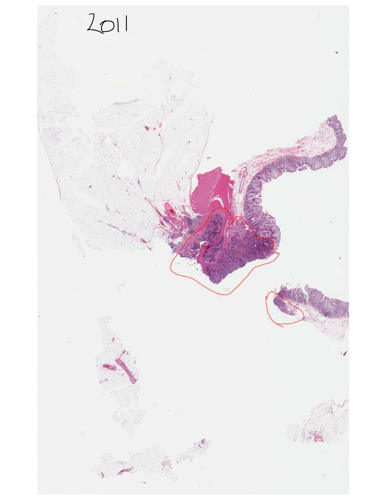

In [8]:
thumbnail(imshow(annotated_img), (500,500))

## Detect picture area

In [9]:
annotated_img_gray = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2GRAY)

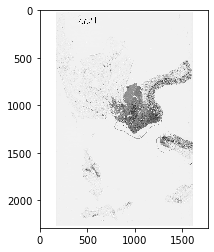

In [10]:
plt.imshow(annotated_img_gray, cmap = 'gray')

In [11]:
annotated_img_thresh = cv2.threshold(annotated_img_gray, 250, 255, cv2.THRESH_BINARY)[1]

In [12]:
len(annotated_img_thresh.shape)

2

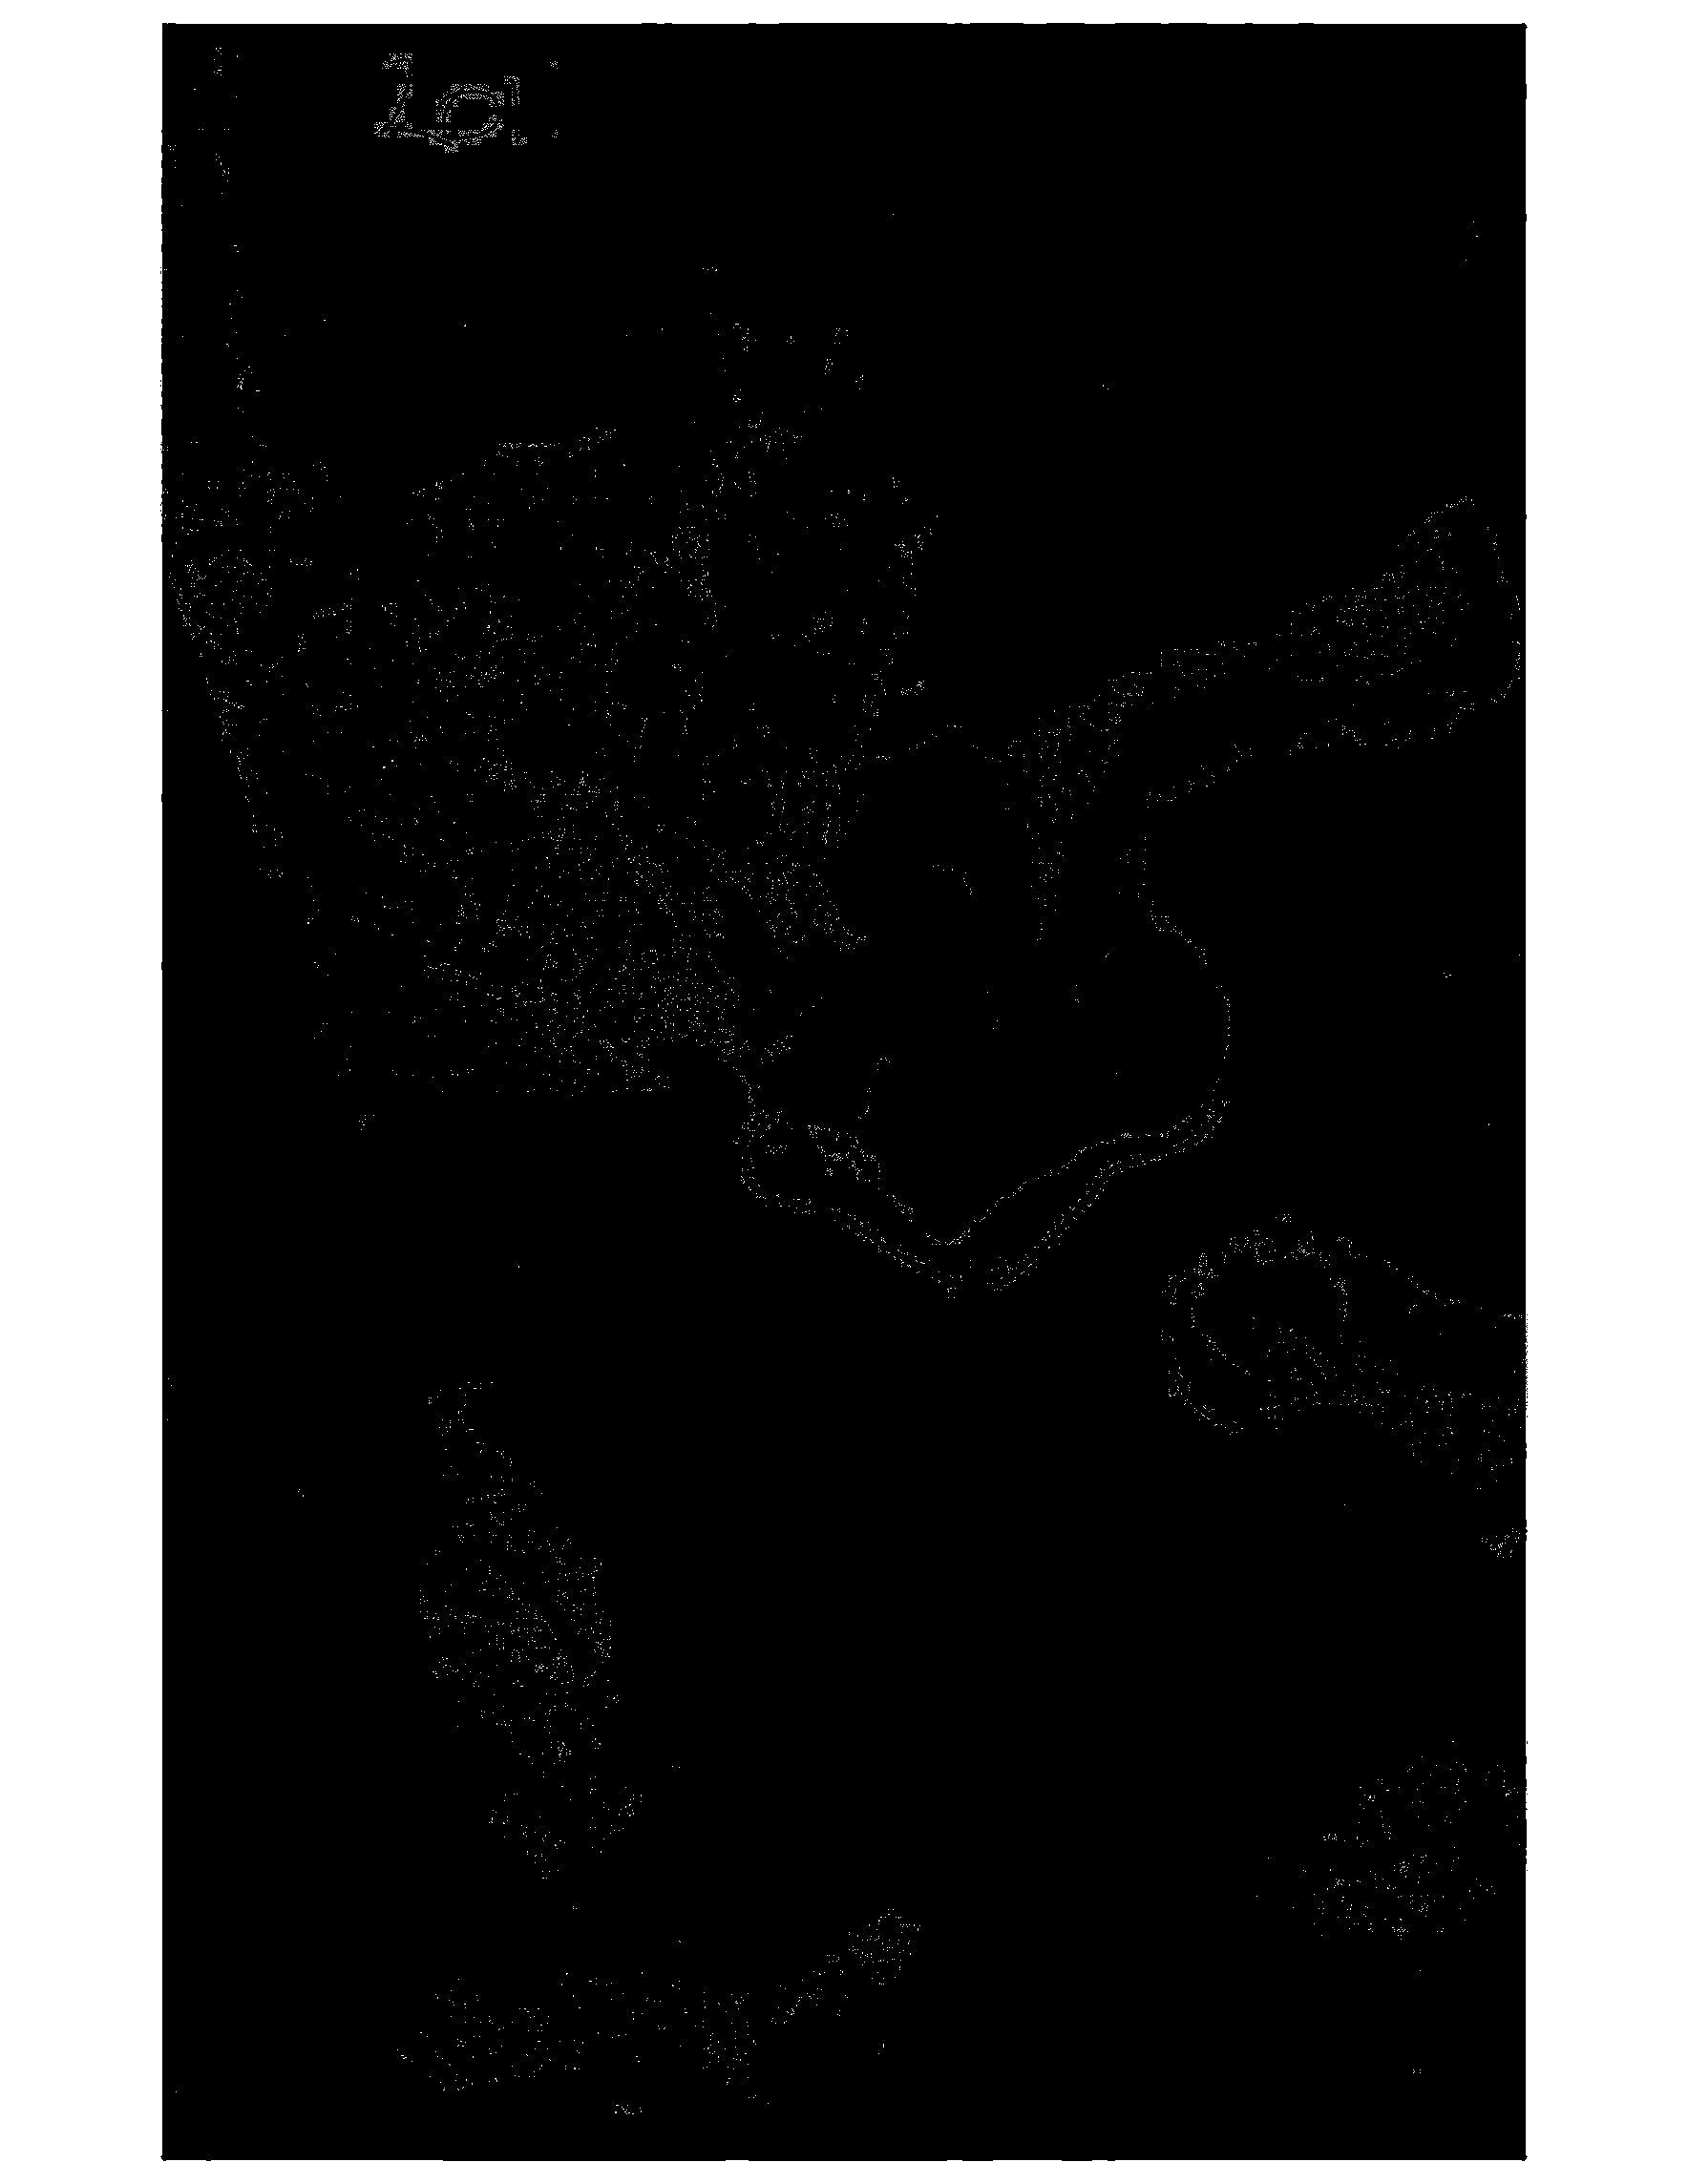

In [13]:
imshow(annotated_img_thresh)

In [14]:
#Close image
kernal_5 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
# closed = cv2.morphologyEx(annotated_img_thresh, cv2.MORPH_CLOSE, kernal_5)
# imshow_gray(closed)

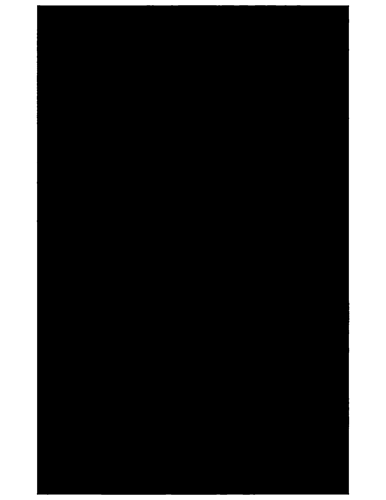

In [15]:
opened = cv2.morphologyEx(annotated_img_thresh, cv2.MORPH_OPEN, kernal_5)
thumbnail(imshow(opened), (500,500))

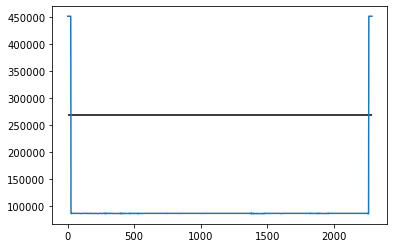

In [16]:
horizontal_px_sums = np.sum(opened, axis = 1).astype(np.int64)
plt.plot(horizontal_px_sums)
horizontal_threshold = (np.min(horizontal_px_sums) + np.max(horizontal_px_sums))/2
plt.hlines(horizontal_threshold, 0, len(horizontal_px_sums))

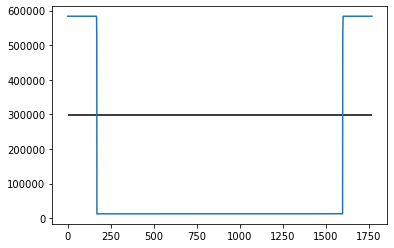

In [17]:
vertical_px_sums = np.sum(opened, axis = 0).astype(np.int64)
plt.plot(vertical_px_sums)
vertical_threshold = (np.min(vertical_px_sums) + np.max(vertical_px_sums))/2
plt.hlines(vertical_threshold, 0, len(vertical_px_sums))

In [18]:
img_rows = np.where(horizontal_px_sums < horizontal_threshold)
y_top = np.min(img_rows)
y_bottom = np.max(img_rows)

In [19]:
img_columns = np.where(vertical_px_sums < vertical_threshold)
x_left = np.min(img_columns)
x_right = np.max(img_columns)

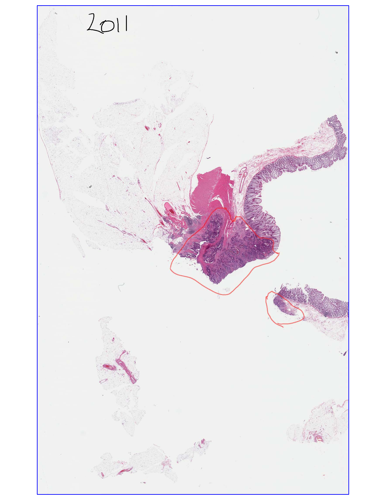

In [20]:
annotated_img_box = annotated_img.copy()
annotated_img_box = cv2.rectangle(annotated_img_box, (x_left, y_top), (x_right, y_bottom), (255,0,0), 2)
thumbnail(imshow(annotated_img_box), (500,500))

In [21]:
#Crop the annotated image to just the slide area
annotated_slide = annotated_img[y_top:y_bottom, x_left:x_right]

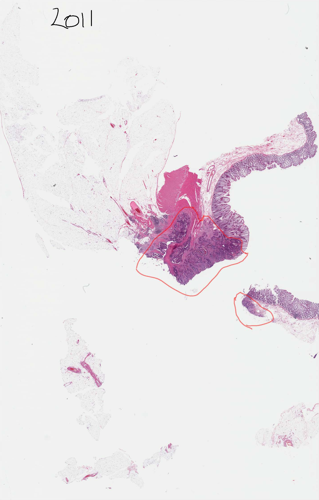

In [22]:
thumbnail(imshow(annotated_slide), (500,500))

## Detect Annotation Lines

In [215]:
#For each unique colour find how many pixels have that colour
px_array_2D = annotated_slide.reshape(-1, annotated_img.shape[-1])
colours, counts = np.unique(px_array_2D, axis = 0, return_counts = True)
colours = colours.astype(np.int16)

Faster implementations available at: https://stackoverflow.com/questions/50899692/most-dominant-color-in-rgb-image-opencv-numpy-python

In [216]:
#Find the most common colours
top_colours = [x for _, x in sorted(zip(counts, colours), key = lambda pair:pair[0], reverse = True)]

In [217]:
def is_gray(bgr_array, tolerance = 3):
    b, g, r = bgr_array[0], bgr_array[1], bgr_array[2]
    bg_diff, br_diff, gr_diff = abs(b-g), abs(b-r), abs(g-r)
    return (bg_diff < tolerance) and (br_diff < tolerance) and (gr_diff < tolerance)

In [218]:
top_colours_filtered = [colour for colour in top_colours if not is_gray(colour, 30)]

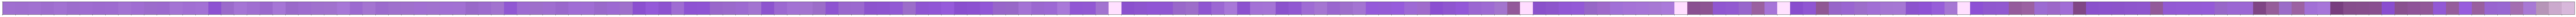

In [219]:
#Plot most common colours
sns.palplot([colour/255 for colour in top_colours_filtered[:200]])

In [220]:
#Find top colours with a high value
top_colours_red = [colour for colour in top_colours_filtered if colour[2] > 150]

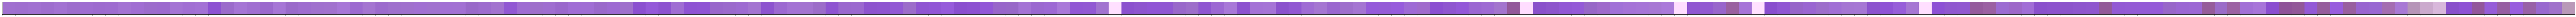

In [221]:
sns.palplot([colour/255 for colour in top_colours_red[:200]])

In [222]:
annotated_slide_hsv = cv2.cvtColor(annotated_slide, cv2.COLOR_BGR2HSV)
annotated_slide_lab = cv2.cvtColor(annotated_slide, cv2.COLOR_BGR2LAB)

In [223]:
# #Testing red detection with HSV
# # Range for lower red
# lower_red = np.array([0, 20, 50])
# upper_red = np.array([30, 255, 255])
# lower_mask = cv2.inRange(annotated_slide_hsv, lower_red, upper_red)

# #Range for upper range
# lower_red = np.array([170, 150, 100])
# upper_red = np.array([180, 255, 255])
# upper_mask = cv2.inRange(annotated_slide_hsv, lower_red, upper_red)

# annotation_mask = lower_mask + upper_mask

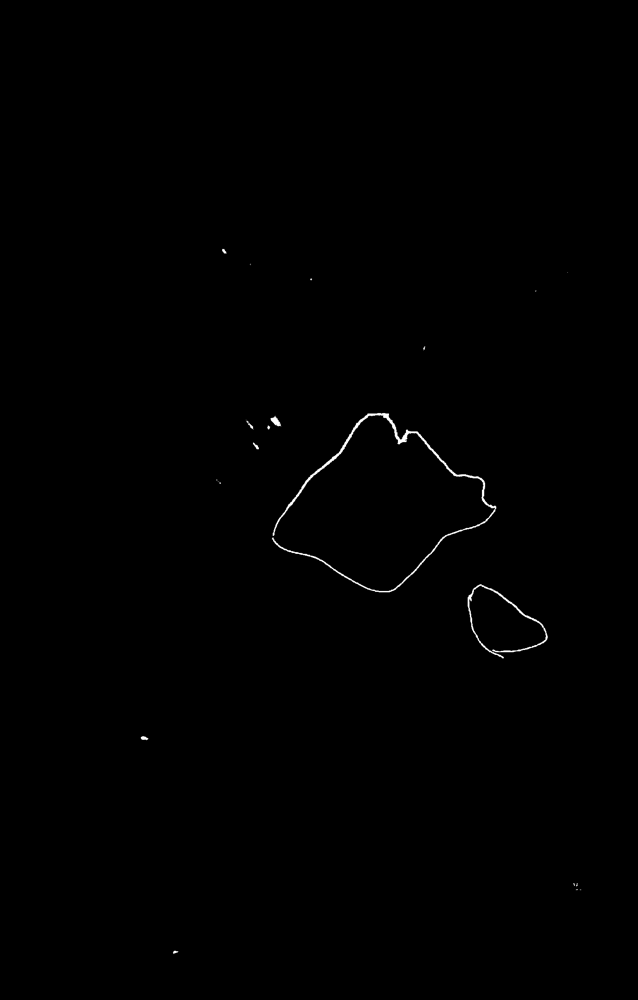

In [257]:
lower_red = np.array([80, 160, 130])
upper_red = np.array([255, 255, 255])

annotation_mask = cv2.inRange(annotated_slide_lab, lower_red, upper_red)

thumbnail(imshow(annotation_mask))

In [225]:
# # order of colours is bgr
# # Green detection bounds
# # lower_colour_bounds = (0, 160, 0)
# # upper_colour_bounds = (150, 255, 150)

# #Red detection bounds
# lower_colour_bounds = (50, 50, 160)
# upper_colour_bounds = (150, 150, 255)

# annotation_mask = cv2.inRange(annotated_slide, lower_colour_bounds, upper_colour_bounds)

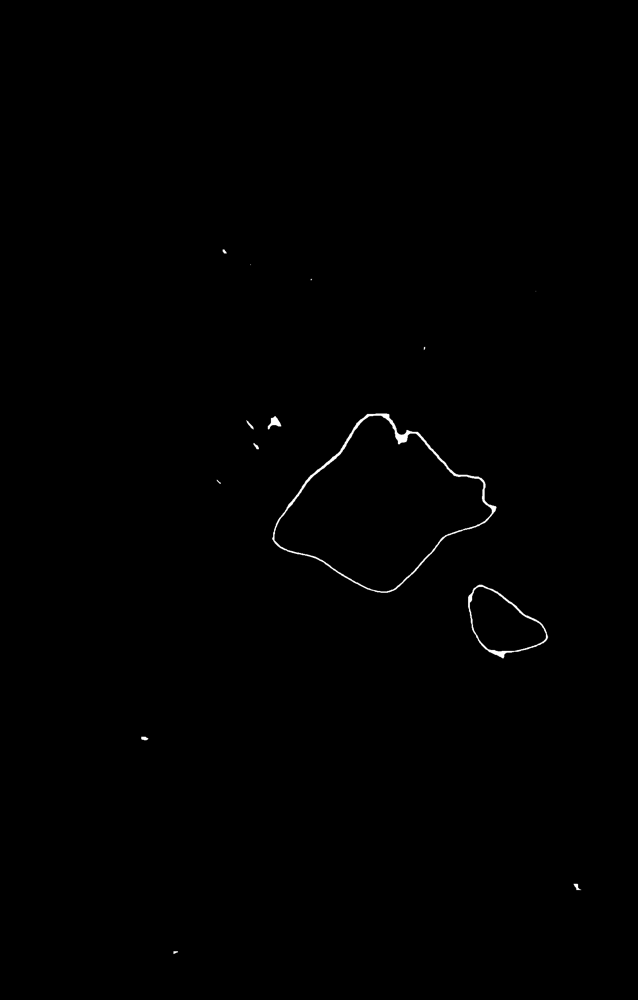

In [244]:
# Fill gaps in contour
kernal_20 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
annotation_mask_closed = cv2.morphologyEx(annotation_mask, cv2.MORPH_CLOSE, kernal_20)
thumbnail(imshow(annotation_mask_closed))

In [208]:
# # Fill gaps in contour 
# kernal = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
# dilated = cv2.dilate(annotation_mask, kernal)
# eroded = cv2.erode(dilated, kernal)
# imshow_gray(eroded)

In [245]:
contours, hierachy = cv2.findContours(annotation_mask_closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [246]:
perimeters = [cv2.arcLength(cnt, True) for cnt in contours]
np.argmax(perimeters)

9

In [247]:
perimeters

[25.656854152679443,
 50.97056233882904,
 38.72792184352875,
 558.0559104681015,
 521.2863574028015,
 24.384775519371033,
 39.21320295333862,
 53.59797930717468,
 102.0832599401474,
 1457.7829592227936,
 1443.096664071083,
 14.242640614509583,
 0.0,
 7.414213538169861,
 2.0,
 27.313708186149597]

In [248]:
hierachy

array([[[ 1, -1, -1, -1],
        [ 2,  0, -1, -1],
        [ 3,  1, -1, -1],
        [ 5,  2,  4, -1],
        [-1, -1, -1,  3],
        [ 6,  3, -1, -1],
        [ 7,  5, -1, -1],
        [ 8,  6, -1, -1],
        [ 9,  7, -1, -1],
        [11,  8, 10, -1],
        [-1, -1, -1,  9],
        [12,  9, -1, -1],
        [13, 11, -1, -1],
        [14, 12, -1, -1],
        [15, 13, -1, -1],
        [-1, 14, -1, -1]]], dtype=int32)

In [249]:
img = cv2.drawContours(annotated_slide.copy(), contours, np.argmax(perimeters), (255, 0, 0), 3)

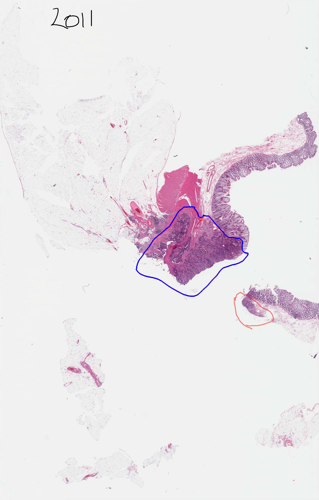

In [250]:
thumbnail(imshow(img), (500, 500))

In [251]:
hierachy

array([[[ 1, -1, -1, -1],
        [ 2,  0, -1, -1],
        [ 3,  1, -1, -1],
        [ 5,  2,  4, -1],
        [-1, -1, -1,  3],
        [ 6,  3, -1, -1],
        [ 7,  5, -1, -1],
        [ 8,  6, -1, -1],
        [ 9,  7, -1, -1],
        [11,  8, 10, -1],
        [-1, -1, -1,  9],
        [12,  9, -1, -1],
        [13, 11, -1, -1],
        [14, 12, -1, -1],
        [15, 13, -1, -1],
        [-1, 14, -1, -1]]], dtype=int32)

To find contours that wrap around our annotations, we want to get the parent contours. <br>
The parent contours are found by selecting contours that have a child (i.e. the 3rd column of hierachy is not -1)

In [252]:
parent_cnts = np.where(hierachy[0][:,2]!= -1)[0]
parent_cnts

array([3, 9])

In [253]:
cnt_mask = np.zeros(annotation_mask_closed.shape[0:2])
for i in parent_cnts:
    cnt = contours[i]
    cnt_mask = cv2.drawContours(cnt_mask, [cnt], 0, 255, -1)
cnt_mask = cnt_mask.astype(np.uint8)

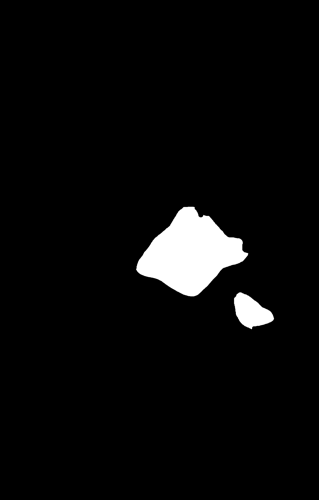

In [255]:
thumbnail(imshow(cnt_mask), (500,500))

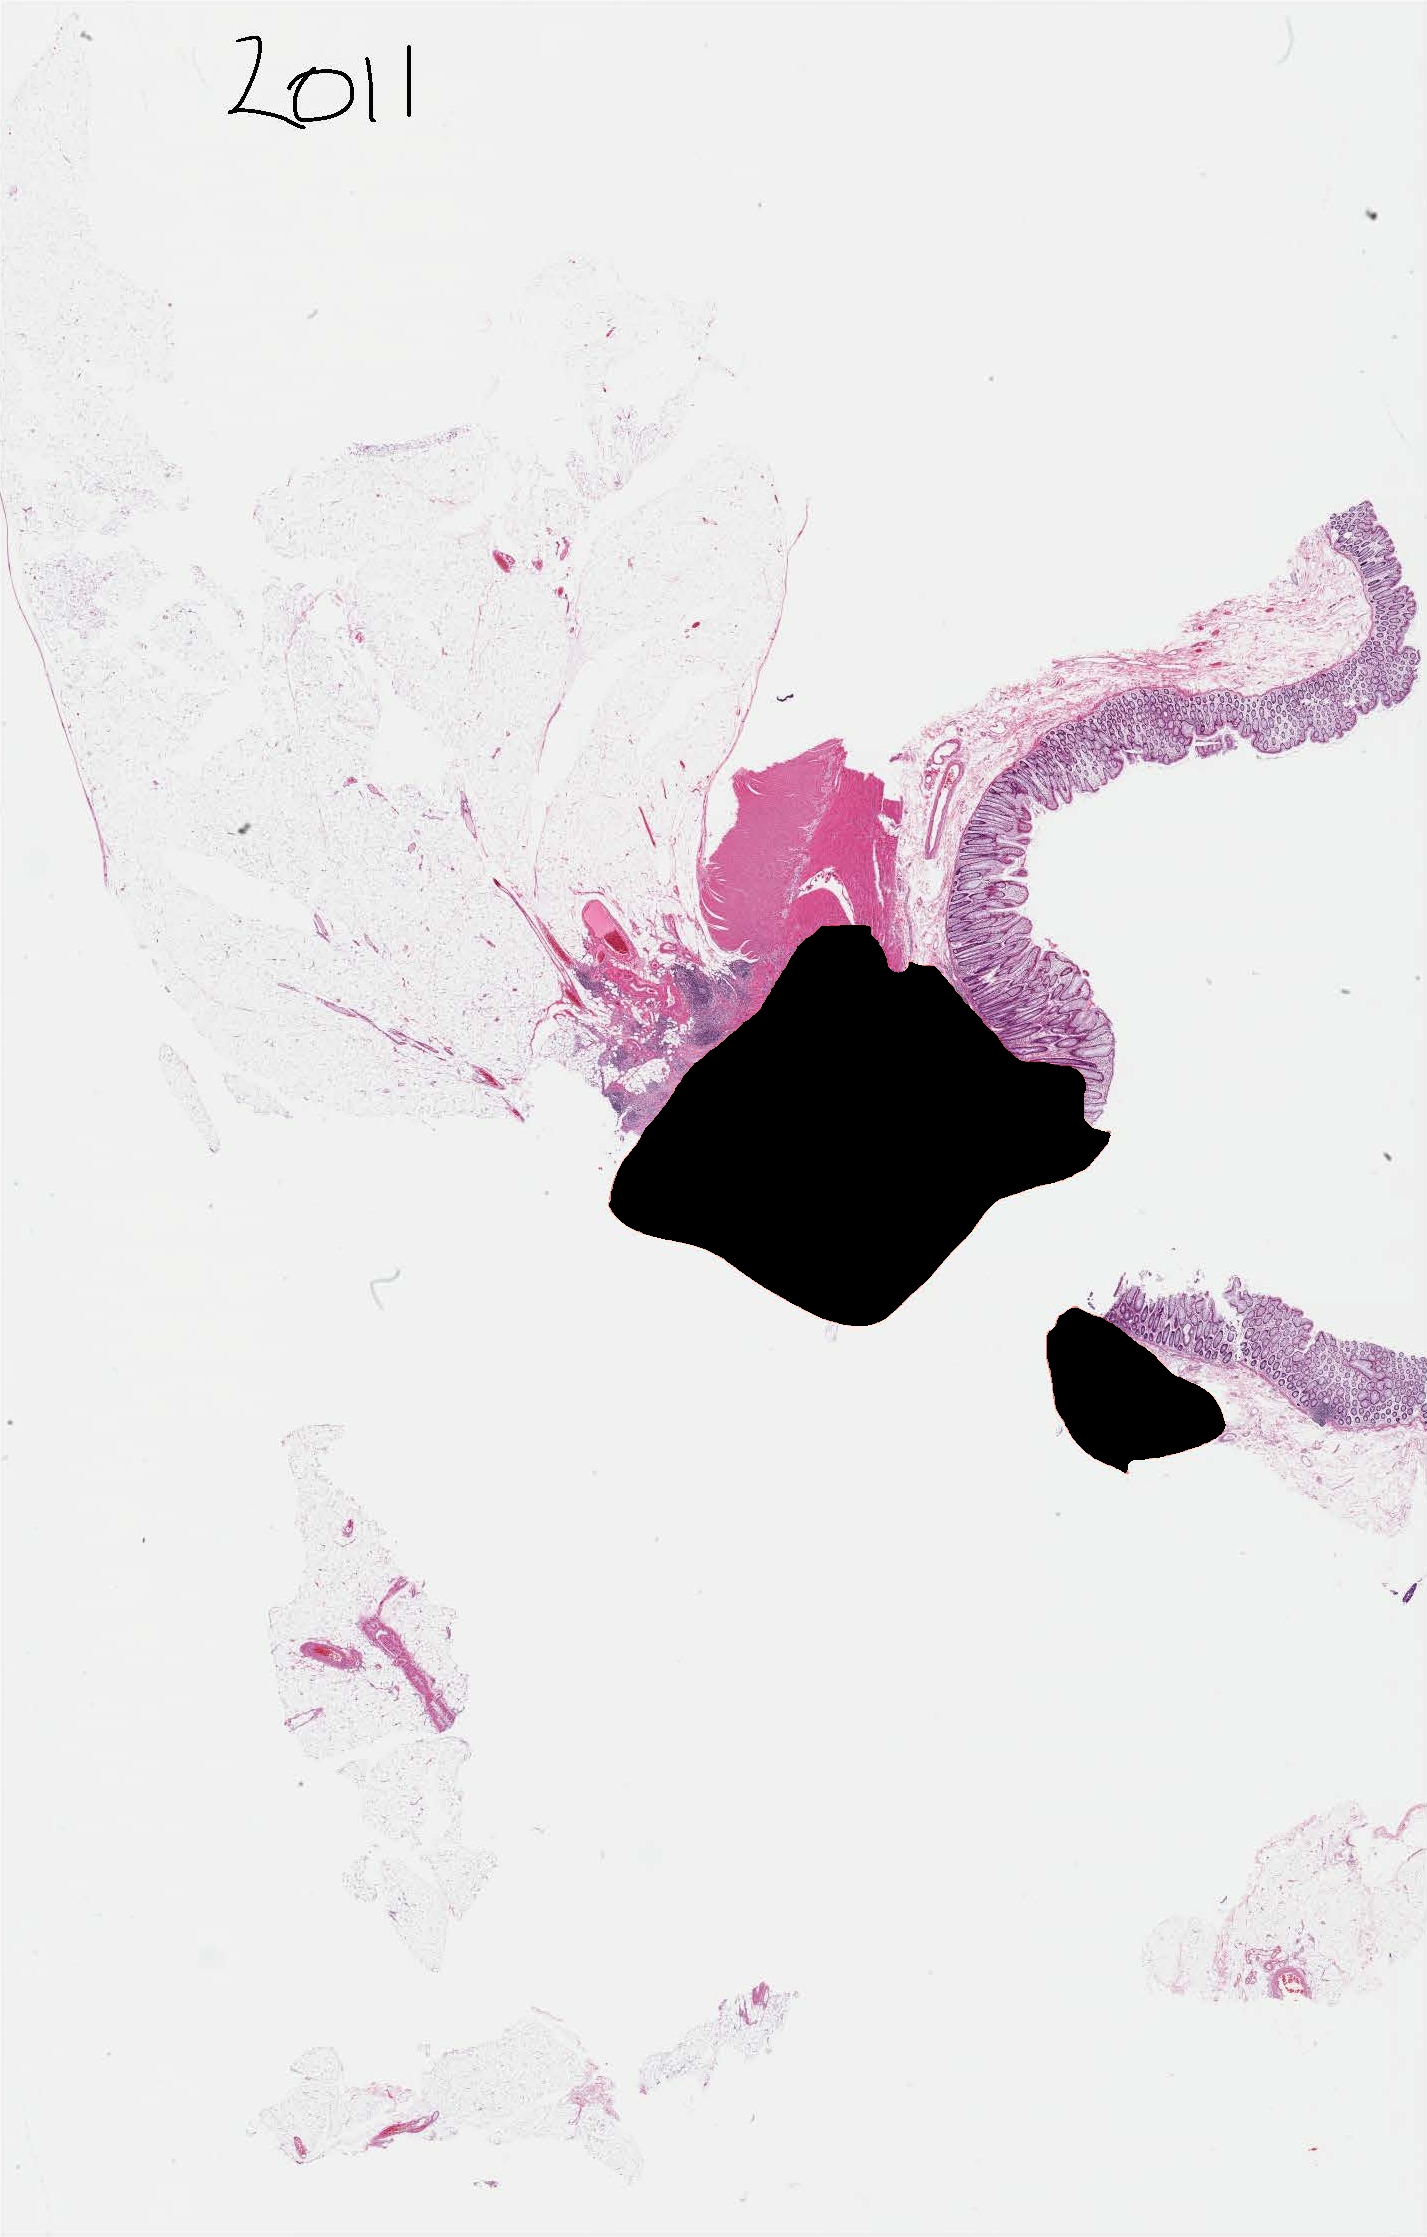

In [256]:
imshow(cv2.bitwise_and(annotated_slide, annotated_slide, mask = cv2.bitwise_not(cnt_mask)))

## Map to Slides

In [262]:
# Find Slides
slides = []
for slide in SLIDES_PATH.glob('*.svs'):
    name = slide.name
    slides.append(name)
slides.sort()
#slides
TP53_slides = [slide for slide in slides if 'TP53' in slide]
HE_slides = [slide for slide in slides if 'HandE' in slide]
Paired_slides = list(zip(TP53_slides, HE_slides))
print('Found {0} pairs of slides'.format(len(Paired_slides)))
for i, pair in enumerate(Paired_slides):
    tp53, he = pair
    verbose_print('{0}. {1}|{2}'.format(i + 1, tp53, he))

Found 35 pairs of slides
1. 1792_T_9500_2_TP53.svs|1792_T_9500_3_HandE.svs
2. 1794_T_9504_2_TP53.svs|1794_T_9504_3_HandE.svs
3. 1798_T_9514_2_TP53.svs|1798_T_9514_3_HandE.svs
4. 1820_N_10545A_4_TP53.svs|1820_N_10545A_2_HandE.svs
5. 1820_T_105452F_4_TP53.svs|1820_T_105452F_2_HandE.svs
6. 1843_T_9561_2_TP53.svs|1843_T_9561_3_HandE.svs
7. 1879_T_9580_2_TP53.svs|1879_T_9580_3_HandE.svs
8. 1910_T_9637_2_TP53.svs|1910_T_9637_3_HandE.svs
9. 1915_T_10464_2_TP53.svs|1915_T_10464_3_HandE.svs
10. 1919_T_10779_2_TP53.svs|1919_T_10779_3_HandE.svs
11. 1928_T_9644_2_TP53.svs|1928_T_9644_3_HandE.svs
12. 1932_T_9876_2_TP53.svs|1932_T_9876_3_HandE.svs
13. 1939_T_9661_2_TP53.svs|1939_T_9661_3_HandE.svs
14. 1957_T_9668_2_TP53.svs|1957_T_9668_3_HandE.svs
15. 2011_T_9699_2_TP53.svs|2011_T_9699_3_HandE.svs
16. 2019_T_9717_2_TP53.svs|2019_T_9717_3_HandE.svs
17. 2023_T_9727_2_TP53.svs|2023_T_9727_3_HandE.svs
18. 2036_T_9729_2_TP53.svs|2036_T_9729_3_HandE.svs
19. 2038_T_11986_2_TP53.svs|2038_T_11986_3_HandE.svs

In [275]:
he_imgs_df = pd.DataFrame(HE_slides, columns = ['HE_Slide_Name'])
for num in he_imgs_df.index:
    slide_name = he_imgs_df.loc[num, 'HE_Slide_Name']
    slide = open_slide(str(SLIDES_PATH.joinpath(slide_name)))
    img_pil = read_slide_at_mag(slide, 0.5).convert('RGB')
    img_cv = np.array(img_pil)[:,]
    he_imgs_df.loc[num, 'Image_Pil'] = img_pil
    
    

In [285]:
he_imgs.index

RangeIndex(start=0, stop=35, step=1)

In [277]:
PREFIX_SHORT = '2011'
SLIDE_NUM = np.argmax([PREFIX_SHORT in slide_name for slide_name in HE_slides])
PREFIX = Paired_slides[SLIDE_NUM][0][:-8]
verbose_print('Processing Slide: {0}'.format(PREFIX))
tp53_name, he_name = Paired_slides[SLIDE_NUM]
tp53_slide = open_slide(str(SLIDES_PATH.joinpath(tp53_name)))
he_slide = open_slide(str(SLIDES_PATH.joinpath(he_name)))

Processing Slide: 2011_T_9699_2_


In [259]:
template_slide = open_slide(str(TEMPLATE_SLIDE_PATH))
template_img = read_slide_at_mag(template_slide, ALIGNMENT_MAG).convert('RGB')

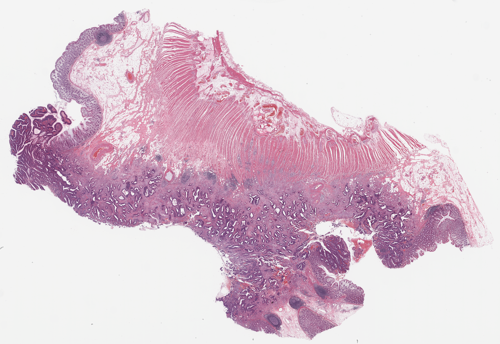

In [265]:
thumbnail(template_img, (500,500))

In [266]:
normaliser = IterativeNormaliser(NORMALISER_METHOD, STANDARDISE_LUMINOSITY)
normaliser.fit_target(template_img)

In [267]:
#Load Slides
he = read_slide_at_mag(he_slide, ALIGNMENT_MAG)
tp53 = read_slide_at_mag(tp53_slide, ALIGNMENT_MAG)

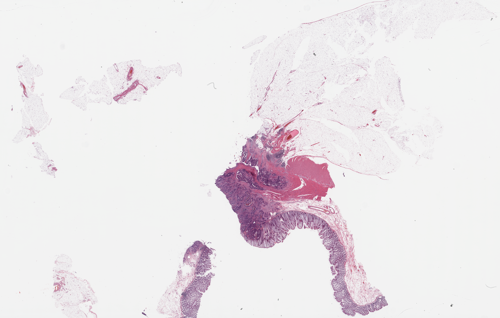

In [268]:
thumbnail(he, (500, 500))

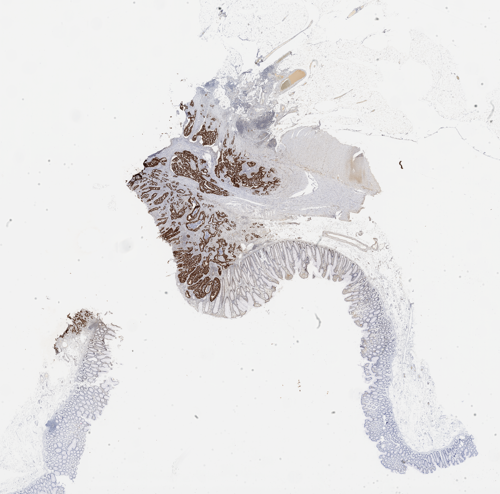

In [269]:
thumbnail(tp53, (500,500))

In [255]:
normaliser.fit_source(he)
he_norm = normaliser.transform_tile(he)

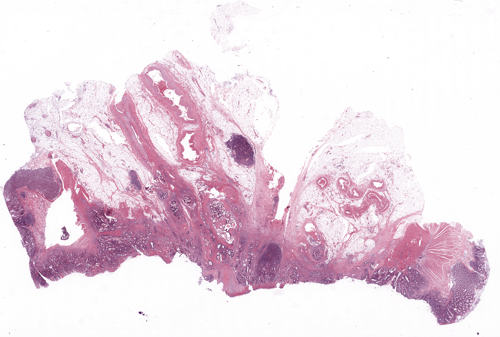

In [256]:
thumbnail(he_norm, (500,500))

In [287]:
ROTATION = -90
annotated_slide_rotated = ndimage.rotate(annotated_slide, ROTATION)

In [270]:
annotated_height, annotated_width = annotated_slide_rotated.shape[:2]
width, height = he_norm.size

In [271]:
width/annotated_width

3.1933050447901934

In [272]:
height/annotated_height

3.192602930914166

In [313]:
annotated_slide_resized = cv2.resize(annotated_slide_rotated, he_norm.size, cv2.INTER_CUBIC)

In [314]:
annotated_slide_rotated.shape

(1433, 2121, 3)

In [315]:
annotated_slide_resized.shape

(4575, 6773, 3)

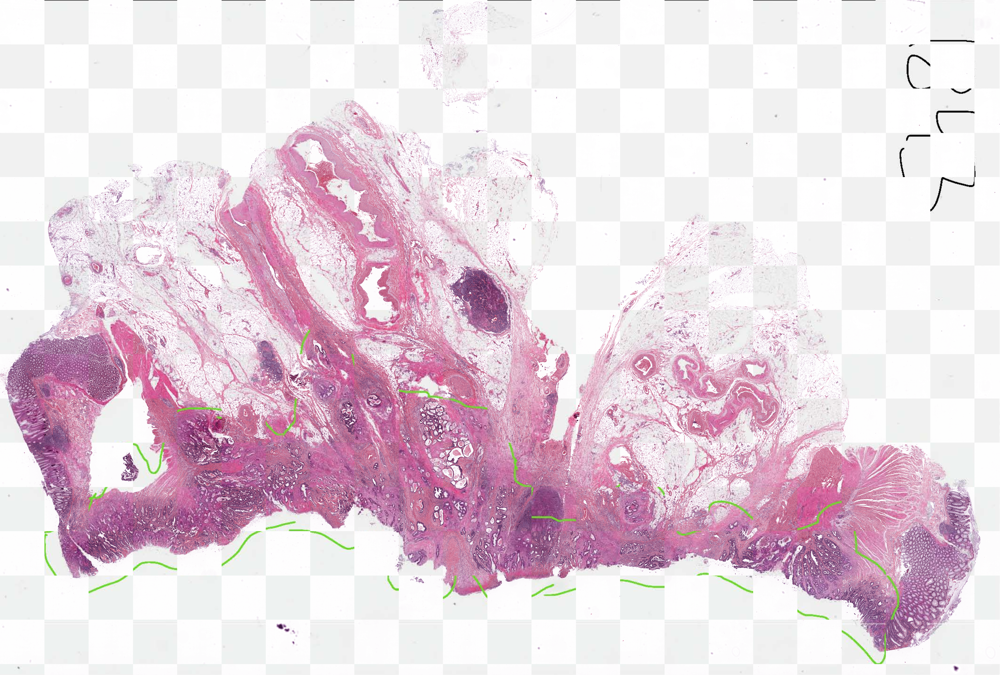

In [316]:
plotter = PlotImageAlignment('mosaic', 300)
overlay = plotter.plot_images(he_norm, imshow(annotated_slide_resized))
thumbnail(overlay)

In [311]:
#Rotate and scale contour mask
cnt_mask_rotated = ndimage.rotate(cnt_mask, ROTATION)
cnt_mask_resized = cv2.resize(cnt_mask_rotated, he_norm.size, cv2.INTER_CUBIC)

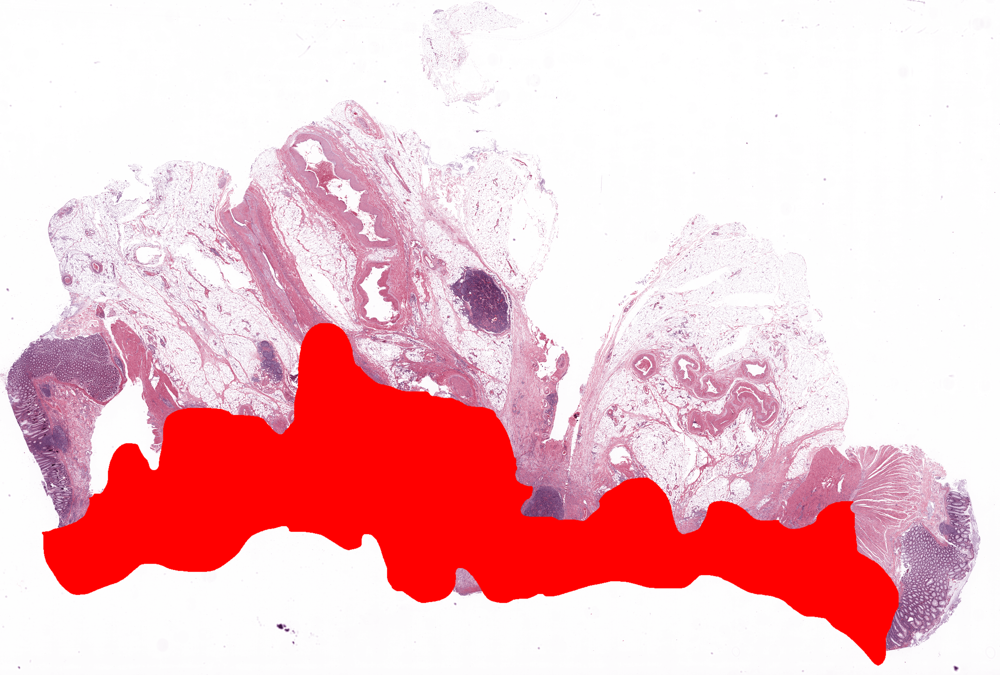

In [317]:
red_img = Image.new('RGB', (he_norm.size), (255, 0 ,0))
cnt_mask_pil = imshow_gray(cnt_mask_resized)
thumbnail(Image.composite(red_img, he_norm , cnt_mask_pil))

In [318]:
tile_size = 299*ALIGNMENT_MAG/TILE_MAG

In [326]:
tgen = tile_gen(cnt_mask_pil, tile_size)
c_mask = np.invert(threshold_mask(tgen, 128).astype(np.bool))

In [327]:
def show_mask(mask):
    mask = mask.astype(np.uint8)
    plt.imshow(np.reshape(mask, mask.shape[::-1]))
    plt.colorbar()

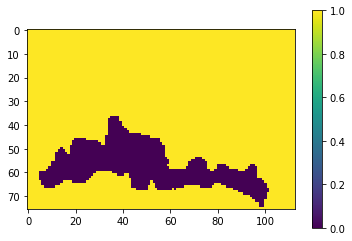

In [328]:
show_mask(c_mask)

In [355]:
#Remove background from H&E Image
he_filtered = filter_green(he_norm)
he_filtered = filter_grays(he_filtered, tolerance = 15)

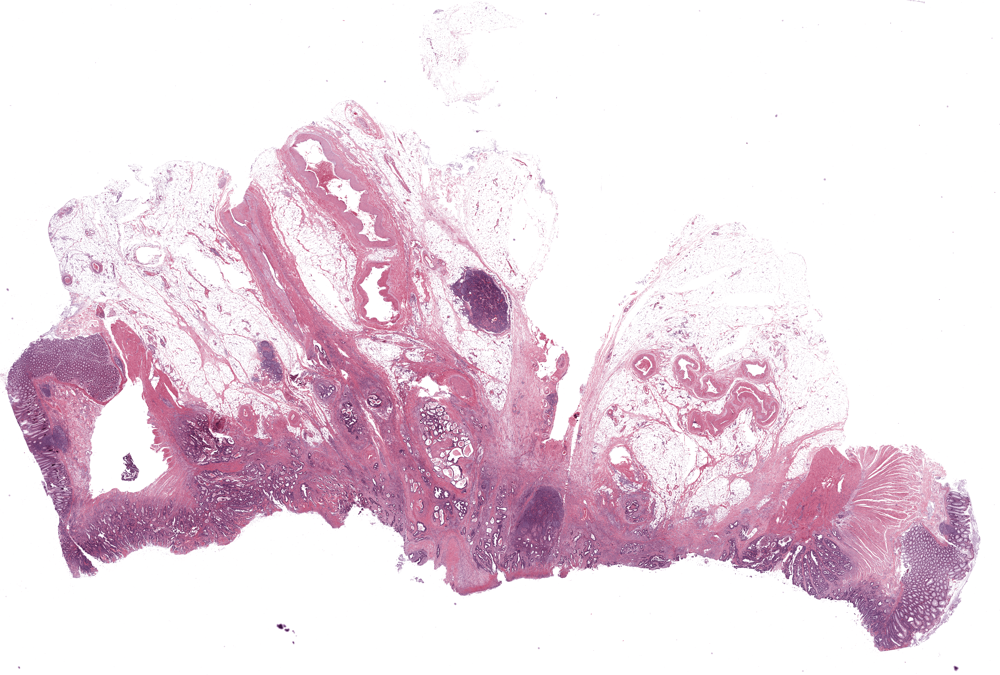

In [356]:
thumbnail(he_filtered)

In [357]:
t_mask_he = tissue_mask(he_filtered, tile_size, 0.01)

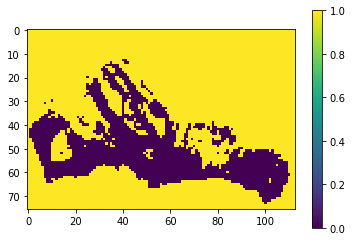

In [358]:
show_mask(t_mask_he)

In [361]:
#Make sure all cancer tiles exist in the tissue mask
c_mask_filtered = np.logical_not(np.logical_not(c_mask) & np.logical_not(t_mask_he))

In [364]:
overlay_he = plot_masks(he_filtered, c_mask_filtered, t_mask_he, tile_size)

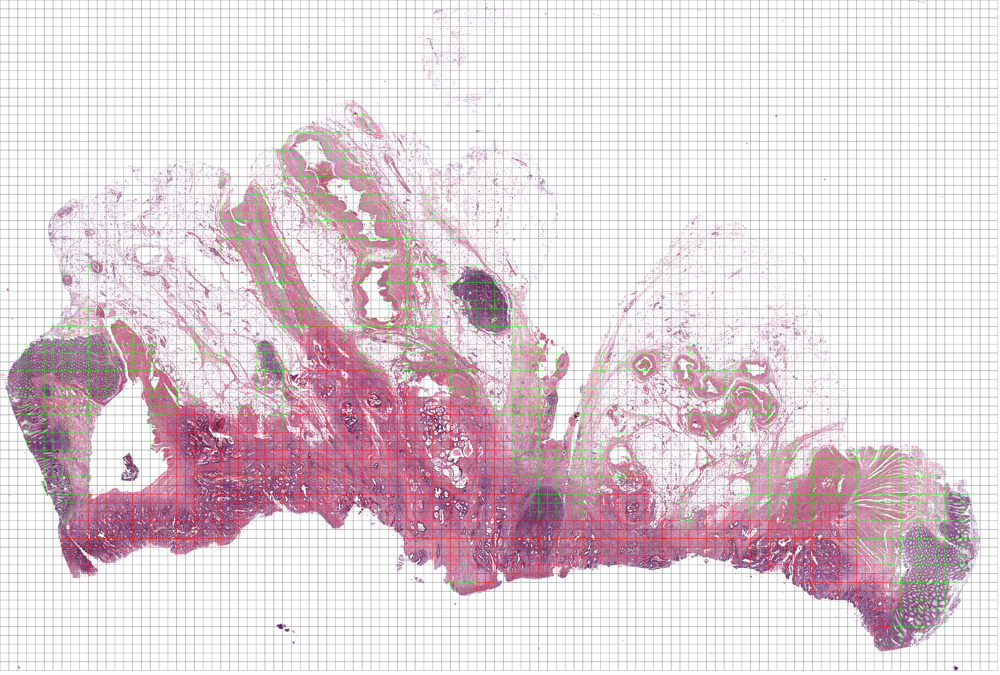

In [365]:
thumbnail(overlay_he)

In [366]:
##############
# Save Tiles #
##############

#Make Directory to save tiles
TILES_PATH = OUTPUT_PATH.joinpath('tiles_' + str(TILE_MAG) + 'x') 
os.makedirs(TILES_PATH, exist_ok = True)


In [368]:
def save_tiles(path, tile_gen, cancer_mask, tissue_mask, prefix = ''):
    os.makedirs(path.joinpath('cancer'), exist_ok = True)
    os.makedirs(path.joinpath('non-cancer'), exist_ok = True)
    x_tiles, y_tiles = next(tile_gen)
    verbose_print('Whole Image Size is {0} x {1}'.format(x_tiles, y_tiles))
    i = 0 
    for tile in tile_gen:
        img = tile.convert('RGB')
        ###
        img_norm = normaliser.transform_tile(img)
        ###
        #Name tile as horizontal position _ vertical position starting at (0,0)
        tile_name = prefix + str(np.floor_divide(i,x_tiles)) + '_' +  str(i%x_tiles) 
        if cancer_mask.ravel()[i] == 0:
            img_norm.save(path.joinpath('cancer', tile_name + '.jpeg'), 'JPEG')
        elif tissue_mask.ravel()[i] == 0:
            img_norm.save(path.joinpath('non-cancer', tile_name + '.jpeg'), 'JPEG')
        i += 1
    verbose_print('Exported tiles for {0}'.format(prefix))

In [370]:
tgen = tile_gen_at_mag(he_slide, TILE_MAG, 299)
save_tiles(TILES_PATH, tgen, c_mask_filtered, t_mask_he, prefix = PREFIX)

Whole Image Size is 113 x 76
Exported tiles for 1843_T_9561_2_
